<a href="https://colab.research.google.com/github/alonsosilvaallende/Churn-prediction-homework/blob/master/Churn_in_a_telecom_operator_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Churn prediction in a telco

Treselle Systems, a data consulting service, [analyzed customer churn data using logistic regression](http://www.treselle.com/blog/customer-churn-logistic-regression-with-r/).

We will use that dataset to do our analysis. The dataset includes information about:

+ Customers who left within the last month: the column is called Churn
+ Services that each customer has signed up for: phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
+ Customer account information: how long they've been a customer, contract, payment method, paperless billing, monthly charges, and total charges
+ Demographic info about customers: gender, age range, and if they have partners and dependents

In [7]:
!pip install -q lifelines

     |████████████████████████████████| 337kB 4.8MB/s 


In [8]:
!pip install -q scikit-survival

     |████████████████████████████████| 1.8MB 5.0MB/s 
     |████████████████████████████████| 153kB 37.9MB/s 


In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
plt.style.use('seaborn')

In [0]:
churn_data = pd.read_csv(
'https://raw.githubusercontent.com/treselle-systems/customer_churn_analysis/master/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
churn_data.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


In [4]:
N = churn_data.shape[0]
churned = len(churn_data.query("Churn == 'Yes'"))
notChurned = len(churn_data.query("Churn == 'No'"))

print(f'customers: {N}\n')
print(f"customers who churned: {churned}")
print(f"customers who haven't churned yet: {notChurned}\n")
print(f'percentage of customers who churned: {100*churned/len(churn_data):.0f}%')
print(f"percentage of customers who haven't churned yet: {100*notChurned/len(churn_data):.0f}%")

customers: 7043

customers who churned: 1869
customers who haven't churned yet: 5174

percentage of customers who churned: 27%
percentage of customers who haven't churned yet: 73%


In [0]:
churn_data['Churn'] = churn_data['Churn'] == 'Yes'

In [0]:
# Drop customerID column
churn_data = churn_data.drop('customerID', axis=1)

# Drop TotalCharges column: otherwise together with MonthlyCharges you can deduce how many months you have been subscribed
churn_data = churn_data.drop('TotalCharges', axis=1)

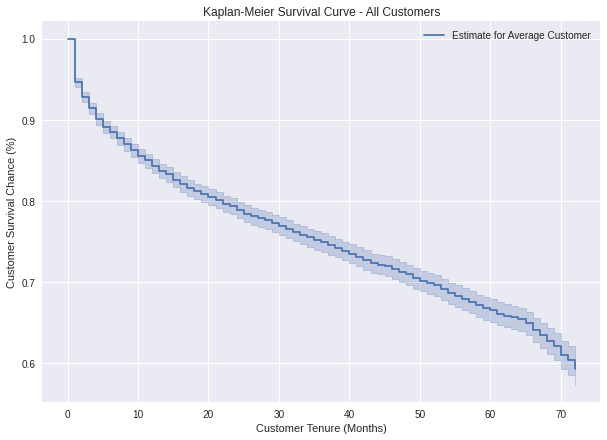

In [9]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(churn_data['tenure'], churn_data['Churn'], label='Estimate for Average Customer')
fig, ax = plt.subplots(figsize=(10,7))
kmf.plot(ax=ax)
ax.set_title('Kaplan-Meier Survival Curve - All Customers')
ax.set_xlabel('Customer Tenure (Months)')
ax.set_ylabel('Customer Survival Chance (%)')
plt.show()

In [0]:
import altair as alt

In [0]:
data = pd.DataFrame()
data = kmf.survival_function_
data['lower'] = kmf.confidence_interval_['Estimate for Average Customer_lower_0.95']
data['upper'] = kmf.confidence_interval_['Estimate for Average Customer_upper_0.95']

In [12]:
label = alt.selection_single(
    encodings=['x'], # limit selection to x-axis value
    on='mouseover',  # select on mouseover events
    nearest=True,    # select data point nearest the cursor
    empty='none'     # empty selection includes no data points
)

base = alt.Chart(data.reset_index()).encode(
    x=alt.X('timeline:Q', scale=alt.Scale(zero=False), axis=alt.Axis(title="Customer tenure (months)"))
)

line = base.mark_line(point=False).encode(
    y=alt.Y('Estimate for Average Customer', scale=alt.Scale(zero=False), axis=alt.Axis(title='Customer survival probability')),
    color=alt.value('blue'),
    tooltip = ['timeline', 'Estimate for Average Customer']
)

band = alt.Chart(data.reset_index()).mark_area(
    opacity=0.5
).encode(
    x=alt.X('timeline:Q', scale=alt.Scale(zero=False)),
    y='lower:Q',
    y2='upper:Q'
)

alt.layer(
    line, # base line chart
    band,
    alt.Chart().mark_rule(color='#aaa').encode(
        x = alt.X('timeline:Q', scale=alt.Scale(zero=False), sort=None)
    ).transform_filter(label),
        # add circle marks for selected time points, hide unselected points
    base.mark_circle(size=80).encode(
        y=alt.Y('Estimate for Average Customer', scale=alt.Scale(zero=False), axis=alt.Axis(title='Customer survival probability')),
        opacity=alt.condition(label, alt.value(1), alt.value(0))
    ).add_selection(label),
        # add white stroked text to provide a legible background for labels
    base.mark_text(align='left', dx=5, dy=-5, stroke='white', strokeWidth=2).encode(
        text='Estimate for Average Customer:Q'
    ).transform_filter(label),
        # add text labels for stock prices
    base.mark_text(align='left', dx=5, dy=-5).encode(
        text='Estimate for Average Customer:Q'
    ).transform_filter(label),
    
    data=data.reset_index()
).properties(
    title=f'Kaplan-Meier Survival Curve - All Customers',
    width=600
)

alt.LayerChart(...)